In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt
import matplotlib.cm as colormap
plt.rcParams['image.cmap'] = 'Paired'

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (VGG19 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG19(weights='imagenet', input_shape=image_shape, include_top=False)

In [7]:
filename = 'malimg-vgg19features.npy'
if os.path.exists(filename):
    print("Loading VGG19 extracted features from %s ..." %(filename))
    vgg19features = np.load(filename)
else:
    print("Extracting features from VGG19 layers ...")
    vgg19features = base_model.predict(X)
    print("Saving VGG19 extracted features into %s ..." %(filename))
    np.save(filename, vgg19features)

Loading VGG19 extracted features from malimg-vgg19features.npy ...


In [8]:
vgg19features.shape

(9339, 7, 7, 512)

In [9]:
vgg19features = np.reshape(vgg19features,(vgg19features.shape[0],-1))

In [10]:
vgg19features.shape

(9339, 25088)

In [11]:
# Training top_model
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv, verbose=10, n_jobs=15)
top_model.fit(vgg19features,y)  # Training 

Fitting 5 folds for each of 169 candidates, totalling 845 fits
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, g

[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed: 116.3min


[CV] .............. C=0.01, gamma=1e-08, score=0.315846, total=74.1min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.401499, total=74.8min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.401499, total=75.3min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.401499, total=75.7min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.315846, total=79.3min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-09, score=0.315846, total=79.2min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.401499, total=78.9min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .

[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed: 129.8min


[CV] .............. C=0.01, gamma=1e-08, score=0.315846, total=83.6min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.401499, total=81.0min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-09, score=0.315846, total=81.9min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.315846, total=81.2min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.717880, total=57.2min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.716809, total=57.0min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.718415, total=59.8min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .

[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed: 226.5min


[CV] .............. C=0.01, gamma=1e-05, score=0.564240, total=78.4min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.569058, total=80.0min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.566916, total=87.4min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.570664, total=88.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.572805, total=89.5min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............ C=0.01, gamma=0.0001, score=0.401499, total=208.3min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............ C=0.01, gamma=0.0001, score=0.401499, total=214.0min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .

[Parallel(n_jobs=15)]: Done  31 tasks      | elapsed: 439.3min


[CV] ............. C=0.01, gamma=0.001, score=0.401499, total=181.6min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............. C=0.01, gamma=0.001, score=0.401499, total=187.3min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............. C=0.01, gamma=0.001, score=0.401499, total=184.9min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=0.01, score=0.401499, total=179.4min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............. C=0.01, gamma=0.001, score=0.401499, total=196.0min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.01, score=0.401499, total=187.2min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.01, score=0.401499, total=210.9min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .

[Parallel(n_jobs=15)]: Done  42 tasks      | elapsed: 647.8min


[CV] ............... C=0.01, gamma=0.1, score=0.401499, total=202.2min
[CV] C=0.01, gamma=100.0 .............................................
[CV] ............... C=0.01, gamma=0.1, score=0.401499, total=200.5min
[CV] C=0.01, gamma=100.0 .............................................
[CV] ............... C=0.01, gamma=0.1, score=0.401499, total=203.4min
[CV] C=0.01, gamma=100.0 .............................................
[CV] ............... C=0.01, gamma=1.0, score=0.401499, total=183.9min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............... C=0.01, gamma=1.0, score=0.401499, total=183.2min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............... C=0.01, gamma=1.0, score=0.401499, total=185.1min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............... C=0.01, gamma=1.0, score=0.401499, total=184.5min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] .

[Parallel(n_jobs=15)]: Done  55 tasks      | elapsed: 770.8min


[CV] ............... C=0.1, gamma=1e-09, score=0.315846, total=65.2min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.1, gamma=1e-09, score=0.315846, total=63.8min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.1, gamma=1e-09, score=0.315846, total=69.2min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.1, gamma=1e-09, score=0.315846, total=71.2min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.1, gamma=1e-09, score=0.315846, total=67.8min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............ C=0.01, gamma=1000.0, score=0.401499, total=181.5min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............ C=0.01, gamma=1000.0, score=0.401499, total=181.1min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .

[Parallel(n_jobs=15)]: Done  68 tasks      | elapsed: 901.2min


[CV] ............. C=0.01, gamma=100.0, score=0.401499, total=202.7min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.401499, total=64.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............ C=0.01, gamma=1000.0, score=0.401499, total=183.4min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.401499, total=65.2min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.959850, total=21.5min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.961991, total=23.5min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.962527, total=25.5min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] .

[Parallel(n_jobs=15)]: Done  83 tasks      | elapsed: 994.9min


[CV] ............... C=0.1, gamma=1e-08, score=0.401499, total=70.1min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.401499, total=69.6min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.794433, total=60.2min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.798715, total=60.6min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.793897, total=60.4min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.792827, total=65.0min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.797645, total=67.3min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed: 1252.0min


[CV] ............... C=0.1, gamma=0.01, score=0.450214, total=197.0min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .............. C=0.1, gamma=0.001, score=0.466274, total=224.2min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .............. C=0.1, gamma=0.001, score=0.464668, total=212.0min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ............... C=0.1, gamma=0.01, score=0.449143, total=199.1min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] .............. C=0.1, gamma=0.001, score=0.465739, total=220.6min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ............... C=0.1, gamma=0.01, score=0.449143, total=212.8min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ............... C=0.1, gamma=0.01, score=0.444325, total=219.6min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=15)]: Done 115 tasks      | elapsed: 1519.0min


[CV] ................ C=0.1, gamma=1.0, score=0.449143, total=221.7min
[CV] C=1.0, gamma=1e-09 ..............................................
[CV] ............... C=0.1, gamma=10.0, score=0.450214, total=219.9min
[CV] C=1.0, gamma=1e-09 ..............................................
[CV] ............... C=0.1, gamma=10.0, score=0.449143, total=217.2min
[CV] C=1.0, gamma=1e-09 ..............................................
[CV] ............... C=0.1, gamma=10.0, score=0.444325, total=220.4min
[CV] C=1.0, gamma=1e-09 ..............................................
[CV] ............... C=0.1, gamma=10.0, score=0.449143, total=220.4min
[CV] C=1.0, gamma=1e-09 ..............................................
[CV] ............... C=1.0, gamma=1e-09, score=0.401499, total=69.2min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ............... C=1.0, gamma=1e-09, score=0.401499, total=74.4min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] .

[Parallel(n_jobs=15)]: Done 132 tasks      | elapsed: 1745.3min


[CV] C=1.0, gamma=1e-06 ..............................................
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............. C=0.1, gamma=1000.0, score=0.450214, total=197.4min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.974839, total=17.2min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.821734, total=54.5min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] .............. C=0.1, gamma=100.0, score=0.449143, total=220.8min
[CV] C=1.0, gamma=1e-05 ..............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.966809, total=19.5min
[CV] C=1.0, gamma=1e-05 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.820664, total=54.4min
[CV] C=1.0, gamma=1e-05 ..............................................
[CV] .

[Parallel(n_jobs=15)]: Done 151 tasks      | elapsed: 1849.3min


[CV] ............... C=1.0, gamma=1e-05, score=0.928266, total=68.7min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.933619, total=69.6min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.929336, total=69.9min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.930407, total=69.4min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] .............. C=1.0, gamma=0.001, score=0.502141, total=236.3min
[CV] C=1.0, gamma=0.1 ................................................
[CV] .............. C=1.0, gamma=0.001, score=0.498929, total=236.8min
[CV] C=1.0, gamma=0.1 ................................................
[CV] ............. C=1.0, gamma=0.0001, score=0.594754, total=261.8min
[CV] C=1.0, gamma=0.1 ................................................
[CV] .

[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed: 2183.9min


[CV] ................ C=1.0, gamma=0.1, score=0.476981, total=252.2min
[CV] C=1.0, gamma=100.0 ..............................................
[CV] ................ C=1.0, gamma=0.1, score=0.476445, total=256.4min
[CV] ................ C=1.0, gamma=0.1, score=0.476981, total=252.8min
[CV] C=1.0, gamma=100.0 ..............................................
[CV] C=1.0, gamma=100.0 ..............................................
[CV] ................ C=1.0, gamma=0.1, score=0.473769, total=253.7min
[CV] C=1.0, gamma=100.0 ..............................................
[CV] ................ C=1.0, gamma=1.0, score=0.476445, total=250.8min
[CV] C=1.0, gamma=100.0 ..............................................
[CV] ................ C=1.0, gamma=0.1, score=0.476981, total=255.0min
[CV] C=1.0, gamma=1000.0 .............................................
[CV] ................ C=1.0, gamma=1.0, score=0.476445, total=254.2min
[CV] C=1.0, gamma=1000.0 .............................................
[CV] .

[Parallel(n_jobs=15)]: Done 191 tasks      | elapsed: 2618.2min


[CV] .............. C=10.0, gamma=1e-08, score=0.972698, total=20.1min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.973233, total=20.0min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.967345, total=20.2min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.967345, total=17.8min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.988223, total=11.4min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.988223, total=11.3min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.990899, total=11.4min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .

[Parallel(n_jobs=15)]: Done 212 tasks      | elapsed: 2711.2min


[CV] C=10.0, gamma=0.001 .............................................
[CV] ............. C=1.0, gamma=1000.0, score=0.473233, total=259.1min
[CV] C=10.0, gamma=0.001 .............................................
[CV] ............. C=1.0, gamma=1000.0, score=0.476445, total=262.3min
[CV] C=10.0, gamma=0.001 .............................................
[CV] ............. C=1.0, gamma=1000.0, score=0.476445, total=248.7min
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.930407, total=62.4min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.929336, total=62.8min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.934690, total=62.7min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.931478, total=72.6min
[CV] C

[Parallel(n_jobs=15)]: Done 235 tasks      | elapsed: 3079.3min


[CV] ............... C=10.0, gamma=0.1, score=0.476981, total=258.0min
[CV] C=10.0, gamma=100.0 .............................................
[CV] ............... C=10.0, gamma=0.1, score=0.473769, total=259.0min
[CV] C=10.0, gamma=100.0 .............................................
[CV] ............... C=10.0, gamma=0.1, score=0.476981, total=261.5min
[CV] C=10.0, gamma=100.0 .............................................
[CV] ............... C=10.0, gamma=1.0, score=0.476445, total=254.8min
[CV] C=10.0, gamma=100.0 .............................................
[CV] ............... C=10.0, gamma=0.1, score=0.477516, total=259.8min
[CV] C=10.0, gamma=100.0 .............................................
[CV] ............... C=10.0, gamma=0.1, score=0.476981, total=263.9min
[CV] C=10.0, gamma=1000.0 ............................................
[CV] ............... C=10.0, gamma=1.0, score=0.476445, total=260.0min
[CV] C=10.0, gamma=1000.0 ............................................
[CV] .

[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed: 3409.9min


[CV] ............. C=100.0, gamma=1e-08, score=0.987687, total= 8.2min
[CV] C=100.0, gamma=1e-07 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.987687, total= 9.5min
[CV] C=100.0, gamma=1e-07 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.988758, total= 8.0min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.987687, total= 7.6min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.989829, total= 7.8min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.989293, total= 8.2min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.987152, total= 8.0min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] .

[Parallel(n_jobs=15)]: Done 283 tasks      | elapsed: 3556.2min


[CV] ............ C=10.0, gamma=1000.0, score=0.473233, total=202.5min
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............ C=10.0, gamma=1000.0, score=0.476445, total=201.4min
[CV] C=100.0, gamma=0.01 .............................................
[CV] ........... C=100.0, gamma=0.0001, score=0.594754, total=192.3min
[CV] C=100.0, gamma=0.1 ..............................................
[CV] ........... C=100.0, gamma=0.0001, score=0.600642, total=200.3min
[CV] C=100.0, gamma=0.1 ..............................................
[CV] ........... C=100.0, gamma=0.0001, score=0.602248, total=193.7min
[CV] C=100.0, gamma=0.1 ..............................................
[CV] ............ C=100.0, gamma=0.001, score=0.505889, total=187.8min
[CV] C=100.0, gamma=0.1 ..............................................
[CV] ........... C=100.0, gamma=0.0001, score=0.602784, total=201.2min
[CV] C=100.0, gamma=0.1 ..............................................
[CV] .

[Parallel(n_jobs=15)]: Done 308 tasks      | elapsed: 4041.5min


[CV] .............. C=100.0, gamma=1.0, score=0.476981, total=210.4min
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] .............. C=100.0, gamma=1.0, score=0.476981, total=207.6min
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] ............. C=100.0, gamma=10.0, score=0.476445, total=207.5min
[CV] C=1000.0, gamma=1e-09 ...........................................
[CV] ............. C=100.0, gamma=10.0, score=0.476445, total=208.9min
[CV] C=1000.0, gamma=1e-09 ...........................................
[CV] ............. C=100.0, gamma=10.0, score=0.476445, total=206.4min
[CV] C=1000.0, gamma=1e-09 ...........................................
[CV] ............. C=100.0, gamma=10.0, score=0.473233, total=209.8min
[CV] C=1000.0, gamma=1e-09 ...........................................
[CV] ............ C=1000.0, gamma=1e-09, score=0.988223, total= 8.9min
[CV] C=1000.0, gamma=1e-09 ...........................................
[CV] .

[Parallel(n_jobs=15)]: Done 335 tasks      | elapsed: 4159.3min


[CV] ............ C=1000.0, gamma=1e-05, score=0.929336, total=57.4min
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.930407, total=56.3min
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.934690, total=56.0min
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.931478, total=58.5min
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.931478, total=56.7min
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] ............ C=100.0, gamma=100.0, score=0.476445, total=219.2min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=100.0, gamma=100.0, score=0.476445, total=217.6min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] .

[Parallel(n_jobs=15)]: Done 362 tasks      | elapsed: 4550.3min


[CV] ............ C=1000.0, gamma=0.01, score=0.486081, total=219.9min
[CV] C=1000.0, gamma=10.0 ............................................
[CV] ............ C=1000.0, gamma=0.01, score=0.484475, total=212.9min
[CV] C=1000.0, gamma=10.0 ............................................
[CV] ............ C=1000.0, gamma=0.01, score=0.483940, total=228.0min
[CV] C=1000.0, gamma=10.0 ............................................
[CV] ............. C=1000.0, gamma=0.1, score=0.476981, total=179.7min
[CV] C=1000.0, gamma=100.0 ...........................................
[CV] ............. C=1000.0, gamma=0.1, score=0.476981, total=183.5min
[CV] C=1000.0, gamma=100.0 ...........................................
[CV] ............. C=1000.0, gamma=0.1, score=0.476981, total=183.2min
[CV] C=1000.0, gamma=100.0 ...........................................
[CV] ............. C=1000.0, gamma=0.1, score=0.473769, total=179.4min
[CV] C=1000.0, gamma=100.0 ...........................................
[CV] .

[Parallel(n_jobs=15)]: Done 391 tasks      | elapsed: 4867.1min


[CV] ........... C=10000.0, gamma=1e-07, score=0.988758, total= 9.8min
[CV] C=10000.0, gamma=1e-06 ..........................................
[CV] ........... C=10000.0, gamma=1e-07, score=0.989829, total= 8.8min
[CV] C=10000.0, gamma=1e-06 ..........................................
[CV] ........... C=10000.0, gamma=1e-07, score=0.989293, total= 8.6min
[CV] C=10000.0, gamma=1e-06 ..........................................
[CV] ........... C=10000.0, gamma=1e-07, score=0.987152, total= 8.0min
[CV] C=10000.0, gamma=1e-06 ..........................................
[CV] ........... C=1000.0, gamma=100.0, score=0.476445, total=177.6min
[CV] C=10000.0, gamma=1e-05 ..........................................
[CV] ........... C=10000.0, gamma=1e-06, score=0.987152, total=13.9min
[CV] C=10000.0, gamma=1e-05 ..........................................
[CV] ........... C=10000.0, gamma=1e-06, score=0.989829, total=12.7min
[CV] C=10000.0, gamma=1e-05 ..........................................
[CV] .

[Parallel(n_jobs=15)]: Done 420 tasks      | elapsed: 5156.0min


[CV] .......... C=10000.0, gamma=0.001, score=0.505889, total=184.5min
[CV] C=10000.0, gamma=1.0 ............................................
[CV] .......... C=10000.0, gamma=0.001, score=0.501606, total=178.0min
[CV] C=10000.0, gamma=1.0 ............................................
[CV] .......... C=10000.0, gamma=0.001, score=0.503212, total=204.6min
[CV] C=10000.0, gamma=1.0 ............................................
[CV] .......... C=10000.0, gamma=0.001, score=0.503212, total=204.7min
[CV] C=10000.0, gamma=1.0 ............................................
[CV] .......... C=10000.0, gamma=0.001, score=0.503747, total=220.1min
[CV] C=10000.0, gamma=1.0 ............................................
[CV] ........... C=10000.0, gamma=0.01, score=0.486081, total=203.7min
[CV] C=10000.0, gamma=10.0 ...........................................
[CV] ........... C=10000.0, gamma=0.01, score=0.481799, total=221.4min
[CV] C=10000.0, gamma=10.0 ...........................................
[CV] .

[Parallel(n_jobs=15)]: Done 451 tasks      | elapsed: 5546.4min


[CV] .......... C=10000.0, gamma=100.0, score=0.476445, total=176.3min
[CV] C=100000.0, gamma=1e-07 .........................................
[CV] .......... C=10000.0, gamma=100.0, score=0.475910, total=179.8min
[CV] C=100000.0, gamma=1e-07 .........................................
[CV] .......... C=100000.0, gamma=1e-08, score=0.987687, total= 7.9min
[CV] C=100000.0, gamma=1e-07 .........................................
[CV] .......... C=100000.0, gamma=1e-08, score=0.989293, total= 8.2min
[CV] C=100000.0, gamma=1e-07 .........................................
[CV] .......... C=100000.0, gamma=1e-08, score=0.989293, total= 8.4min
[CV] C=100000.0, gamma=1e-06 .........................................
[CV] .......... C=100000.0, gamma=1e-08, score=0.987152, total= 7.6min
[CV] C=100000.0, gamma=1e-06 .........................................
[CV] .......... C=100000.0, gamma=1e-07, score=0.988758, total= 9.8min
[CV] C=100000.0, gamma=1e-06 .........................................
[CV] .

[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed: 5825.2min


[CV] ........ C=100000.0, gamma=0.0001, score=0.602248, total=188.2min
[CV] C=100000.0, gamma=0.1 ...........................................
[CV] ........ C=100000.0, gamma=0.0001, score=0.603854, total=180.0min
[CV] C=100000.0, gamma=0.1 ...........................................
[CV] ........ C=100000.0, gamma=0.0001, score=0.600642, total=214.5min
[CV] C=100000.0, gamma=0.1 ...........................................
[CV] ......... C=100000.0, gamma=0.001, score=0.505889, total=184.4min
[CV] C=100000.0, gamma=1.0 ...........................................
[CV] ......... C=100000.0, gamma=0.001, score=0.503747, total=236.3min
[CV] C=100000.0, gamma=1.0 ...........................................
[CV] ......... C=100000.0, gamma=0.001, score=0.501606, total=241.8min
[CV] C=100000.0, gamma=1.0 ...........................................
[CV] ......... C=100000.0, gamma=0.001, score=0.503212, total=243.3min
[CV] C=100000.0, gamma=1.0 ...........................................
[CV] .

[Parallel(n_jobs=15)]: Done 515 tasks      | elapsed: 6424.9min


[CV] .......... C=100000.0, gamma=10.0, score=0.476445, total=299.5min
[CV] C=1000000.0, gamma=1e-07 ........................................
[CV] ......... C=1000000.0, gamma=1e-08, score=0.987687, total=12.4min
[CV] C=1000000.0, gamma=1e-07 ........................................
[CV] ......... C=1000000.0, gamma=1e-08, score=0.989293, total=11.5min
[CV] C=1000000.0, gamma=1e-07 ........................................
[CV] ......... C=1000000.0, gamma=1e-08, score=0.989293, total=11.5min
[CV] C=1000000.0, gamma=1e-07 ........................................
[CV] ......... C=1000000.0, gamma=1e-08, score=0.987152, total=12.2min
[CV] C=1000000.0, gamma=1e-07 ........................................
[CV] ......... C=1000000.0, gamma=1e-07, score=0.988758, total=12.3min
[CV] C=1000000.0, gamma=1e-06 ........................................
[CV] ......... C=1000000.0, gamma=1e-07, score=0.987687, total=13.1min
[CV] C=1000000.0, gamma=1e-06 ........................................
[CV] .

[Parallel(n_jobs=15)]: Done 548 tasks      | elapsed: 6968.5min


[CV] ....... C=1000000.0, gamma=0.0001, score=0.602784, total=304.0min
[CV] C=1000000.0, gamma=0.1 ..........................................
[CV] ....... C=1000000.0, gamma=0.0001, score=0.603854, total=305.5min
[CV] C=1000000.0, gamma=0.1 ..........................................
[CV] ........ C=1000000.0, gamma=0.001, score=0.505889, total=308.8min
[CV] C=1000000.0, gamma=1.0 ..........................................
[CV] ........ C=1000000.0, gamma=0.001, score=0.501606, total=310.4min
[CV] C=1000000.0, gamma=1.0 ..........................................
[CV] ........ C=1000000.0, gamma=0.001, score=0.503747, total=310.9min
[CV] C=1000000.0, gamma=1.0 ..........................................
[CV] ........ C=1000000.0, gamma=0.001, score=0.503212, total=310.3min
[CV] C=1000000.0, gamma=1.0 ..........................................
[CV] ........ C=1000000.0, gamma=0.001, score=0.503212, total=306.8min
[CV] C=1000000.0, gamma=1.0 ..........................................
[CV] .

[Parallel(n_jobs=15)]: Done 583 tasks      | elapsed: 7322.5min


[CV] ........ C=10000000.0, gamma=1e-08, score=0.989293, total= 8.8min
[CV] C=10000000.0, gamma=1e-07 .......................................
[CV] ........ C=10000000.0, gamma=1e-08, score=0.987152, total= 7.8min
[CV] C=10000000.0, gamma=1e-07 .......................................
[CV] ........ C=10000000.0, gamma=1e-07, score=0.988758, total= 8.1min
[CV] C=10000000.0, gamma=1e-06 .......................................
[CV] ........ C=10000000.0, gamma=1e-07, score=0.987687, total= 7.5min
[CV] C=10000000.0, gamma=1e-06 .......................................
[CV] ........ C=10000000.0, gamma=1e-07, score=0.989829, total= 7.6min
[CV] C=10000000.0, gamma=1e-06 .......................................
[CV] ........ C=10000000.0, gamma=1e-07, score=0.989293, total= 8.6min
[CV] C=10000000.0, gamma=1e-06 .......................................
[CV] ........ C=10000000.0, gamma=1e-07, score=0.987152, total= 8.7min
[CV] C=10000000.0, gamma=1e-06 .......................................
[CV] .

[Parallel(n_jobs=15)]: Done 618 tasks      | elapsed: 7705.0min


[CV] ....... C=10000000.0, gamma=0.001, score=0.501606, total=210.1min
[CV] C=10000000.0, gamma=1.0 .........................................
[CV] ....... C=10000000.0, gamma=0.001, score=0.503212, total=188.8min
[CV] C=10000000.0, gamma=1.0 .........................................
[CV] ........ C=10000000.0, gamma=0.01, score=0.481799, total=210.9min
[CV] C=10000000.0, gamma=10.0 ........................................
[CV] ........ C=10000000.0, gamma=0.01, score=0.486081, total=210.2min
[CV] C=10000000.0, gamma=10.0 ........................................
[CV] ........ C=10000000.0, gamma=0.01, score=0.484475, total=213.4min
[CV] C=10000000.0, gamma=10.0 ........................................
[CV] ........ C=10000000.0, gamma=0.01, score=0.479122, total=215.3min
[CV] C=10000000.0, gamma=10.0 ........................................
[CV] ........ C=10000000.0, gamma=0.01, score=0.483940, total=214.1min
[CV] C=10000000.0, gamma=10.0 ........................................
[CV] .

[Parallel(n_jobs=15)]: Done 655 tasks      | elapsed: 8085.1min


[CV] ....... C=100000000.0, gamma=1e-06, score=0.987152, total=11.6min
[CV] C=100000000.0, gamma=1e-05 ......................................
[CV] ....... C=100000000.0, gamma=1e-06, score=0.989829, total=12.3min
[CV] C=100000000.0, gamma=1e-05 ......................................
[CV] ....... C=100000000.0, gamma=1e-06, score=0.990899, total=12.0min
[CV] C=100000000.0, gamma=1e-05 ......................................
[CV] ....... C=100000000.0, gamma=1e-06, score=0.989829, total=13.2min
[CV] C=100000000.0, gamma=1e-05 ......................................
[CV] ....... C=100000000.0, gamma=1e-06, score=0.988758, total=12.9min
[CV] C=100000000.0, gamma=1e-05 ......................................
[CV] ....... C=10000000.0, gamma=100.0, score=0.475910, total=194.0min
[CV] C=100000000.0, gamma=0.0001 .....................................
[CV] ....... C=10000000.0, gamma=100.0, score=0.476445, total=194.3min
[CV] C=100000000.0, gamma=0.0001 .....................................
[CV] .

[Parallel(n_jobs=15)]: Done 692 tasks      | elapsed: 8580.8min


[CV] ........ C=100000000.0, gamma=0.1, score=0.476981, total=192.2min
[CV] C=100000000.0, gamma=100.0 ......................................
[CV] ........ C=100000000.0, gamma=0.1, score=0.473769, total=196.6min
[CV] C=100000000.0, gamma=100.0 ......................................
[CV] ........ C=100000000.0, gamma=0.1, score=0.477516, total=195.9min
[CV] C=100000000.0, gamma=100.0 ......................................
[CV] ........ C=100000000.0, gamma=1.0, score=0.476445, total=198.0min
[CV] C=100000000.0, gamma=1000.0 .....................................
[CV] ........ C=100000000.0, gamma=1.0, score=0.476445, total=197.0min
[CV] C=100000000.0, gamma=1000.0 .....................................
[CV] ........ C=100000000.0, gamma=1.0, score=0.476981, total=213.3min
[CV] C=100000000.0, gamma=1000.0 .....................................
[CV] ........ C=100000000.0, gamma=1.0, score=0.473233, total=213.0min
[CV] C=100000000.0, gamma=1000.0 .....................................
[CV] .

[Parallel(n_jobs=15)]: Done 731 tasks      | elapsed: 8861.1min


[CV] ...... C=1000000000.0, gamma=1e-05, score=0.930407, total=56.6min
[CV] C=1000000000.0, gamma=0.001 .....................................
[CV] ...... C=1000000000.0, gamma=1e-05, score=0.931478, total=54.5min
[CV] C=1000000000.0, gamma=0.001 .....................................
[CV] ...... C=1000000000.0, gamma=1e-05, score=0.934690, total=57.7min
[CV] C=1000000000.0, gamma=0.001 .....................................
[CV] ..... C=100000000.0, gamma=1000.0, score=0.475910, total=196.4min
[CV] C=1000000000.0, gamma=0.001 .....................................
[CV] ...... C=1000000000.0, gamma=1e-05, score=0.931478, total=55.4min
[CV] C=1000000000.0, gamma=0.01 ......................................
[CV] ..... C=100000000.0, gamma=1000.0, score=0.475375, total=199.4min
[CV] C=1000000000.0, gamma=0.01 ......................................
[CV] ..... C=100000000.0, gamma=1000.0, score=0.473233, total=205.9min
[CV] C=1000000000.0, gamma=0.01 ......................................
[CV] .

[Parallel(n_jobs=15)]: Done 770 tasks      | elapsed: 9418.8min


[CV] ..... C=10000000000.0, gamma=1e-09, score=0.989293, total= 8.1min
[CV] C=10000000000.0, gamma=1e-08 ....................................
[CV] ...... C=1000000000.0, gamma=10.0, score=0.473233, total=206.4min
[CV] C=10000000000.0, gamma=1e-08 ....................................
[CV] ..... C=10000000000.0, gamma=1e-09, score=0.987152, total= 7.7min
[CV] C=10000000000.0, gamma=1e-08 ....................................
[CV] ..... C=10000000000.0, gamma=1e-08, score=0.989293, total= 7.7min
[CV] C=10000000000.0, gamma=1e-08 ....................................
[CV] ..... C=10000000000.0, gamma=1e-08, score=0.987687, total= 8.8min
[CV] C=10000000000.0, gamma=1e-08 ....................................
[CV] ...... C=1000000000.0, gamma=10.0, score=0.476445, total=226.4min
[CV] C=10000000000.0, gamma=1e-07 ....................................
[CV] ..... C=10000000000.0, gamma=1e-08, score=0.989293, total= 7.9min
[CV] C=10000000000.0, gamma=1e-07 ....................................
[CV] .

[Parallel(n_jobs=15)]: Done 811 tasks      | elapsed: 9814.0min


[CV] ... C=10000000000.0, gamma=0.0001, score=0.603854, total=212.2min
[CV] C=10000000000.0, gamma=1.0 ......................................
[CV] ... C=10000000000.0, gamma=0.0001, score=0.602784, total=213.5min
[CV] C=10000000000.0, gamma=1.0 ......................................
[CV] .... C=10000000000.0, gamma=0.001, score=0.503212, total=202.9min
[CV] C=10000000000.0, gamma=1.0 ......................................
[CV] ..... C=10000000000.0, gamma=0.01, score=0.484475, total=187.5min
[CV] C=10000000000.0, gamma=1.0 ......................................
[CV] ..... C=10000000000.0, gamma=0.01, score=0.483940, total=190.6min
[CV] C=10000000000.0, gamma=10.0 .....................................
[CV] ..... C=10000000000.0, gamma=0.01, score=0.479122, total=196.2min
[CV] C=10000000000.0, gamma=10.0 .....................................
[CV] .... C=10000000000.0, gamma=0.001, score=0.503212, total=218.8min
[CV] C=10000000000.0, gamma=10.0 .....................................
[CV] .

[Parallel(n_jobs=15)]: Done 845 out of 845 | elapsed: 10292.0min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=1, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=15,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, v

In [12]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 10.0, 'gamma': 9.9999999999999995e-07} - score: 0.9893


In [13]:
top_model.cv_results_

{'mean_fit_time': array([  3927.26973362,   4040.45041466,   3959.84013205,   2915.02320318,
          4405.88204765,  11918.50225635,  10455.28256173,  11167.0333178 ,
         11390.15467696,  10341.99548559,  10870.60644064,  11240.08118982,
         10249.48529434,   3355.12049031,   3365.94705544,   2516.80534701,
          1080.94392252,   3346.49721942,  11325.25541024,  12326.70535879,
         11661.6693891 ,  11450.58248677,  12049.90955744,  12228.73442864,
         11510.78976016,  11732.16291761,   3513.834343  ,   2815.91314559,
           763.52734828,    787.74162235,   3796.90914278,  14877.83316121,
         13849.58089566,  14164.06426439,  14438.50087719,  14413.37975898,
         14296.34633918,  14489.59828606,  14354.1766602 ,   3207.5946094 ,
           881.92114062,    467.96949158,    650.86465063,   3637.76208401,
         13488.8557374 ,  13304.82426867,  13579.76052279,  14857.70132523,
         14727.04270682,  14408.81531324,  11483.68925743,  11483.24432

In [14]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.31585, std: 0.00000, params: {'C': 0.01, 'gamma': 1.0000000000000001e-09},
 mean: 0.31585, std: 0.00000, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.71767, std: 0.00073, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.56874, std: 0.00296, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 100.0},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 1000.0},
 mean: 0.31585, std: 0.00000, params: {'C': 0.100

In [15]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
    ax.set_xscale('log')
    #ax.set_ylim([0.0,1.0])

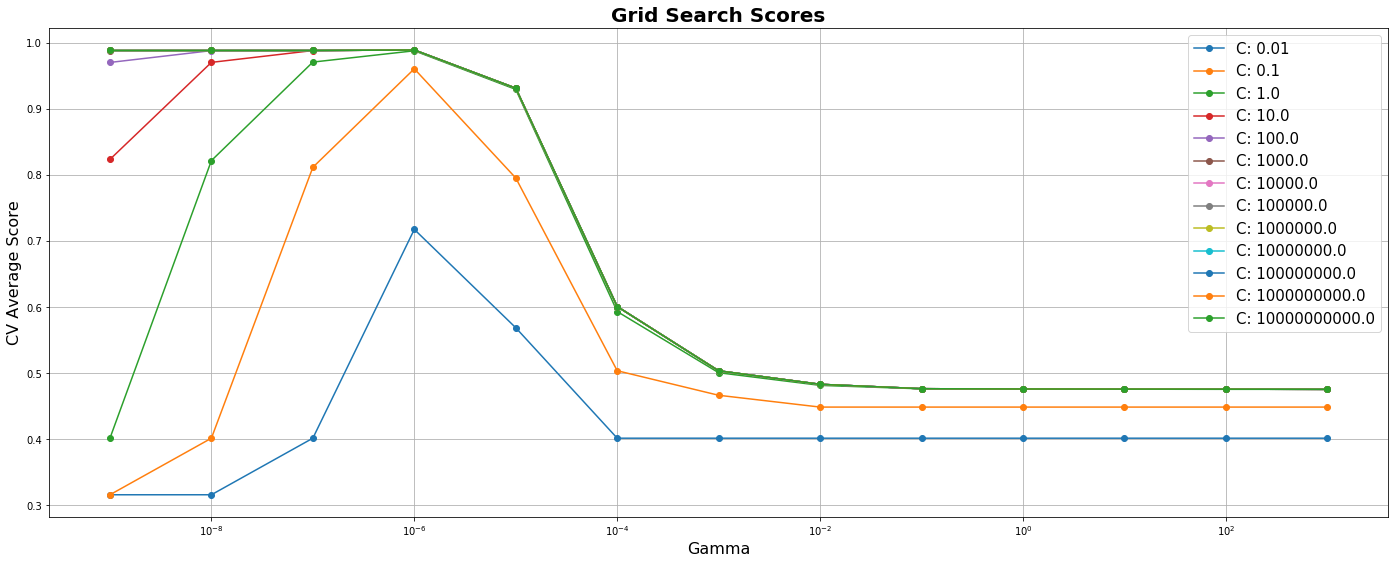

In [16]:
plot_grid_search(top_model.cv_results_,gamma_range,C_range,'Gamma','C')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


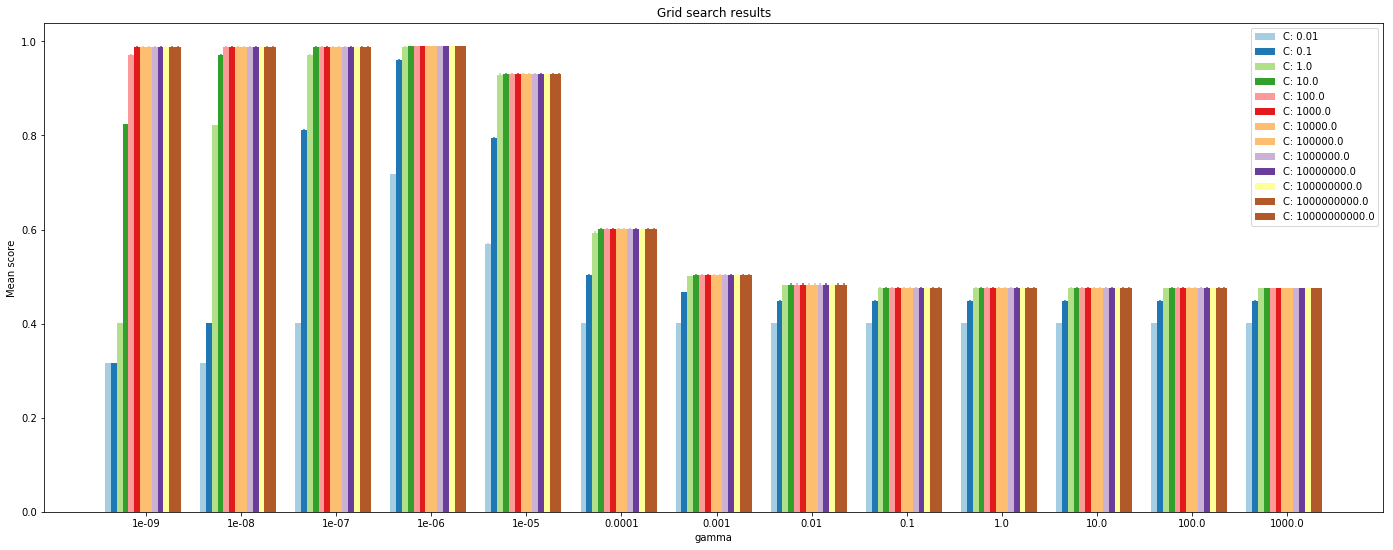

In [17]:
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


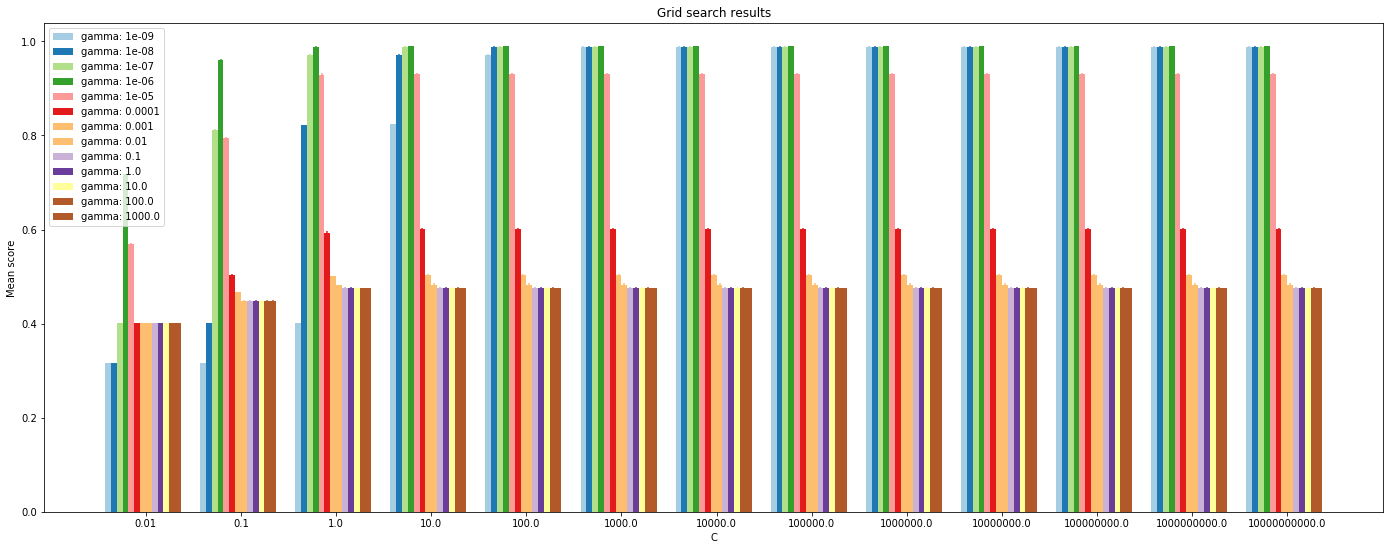

In [18]:
skplot.grid_search(top_model.grid_scores_, change='C', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

In [19]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svm_model = svm.SVC(C=top_model.best_params_['C'],gamma=top_model.best_params_['gamma'])
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(svm_model, vgg19features, y, cv=cv, n_jobs=15, train_sizes=train_sizes)

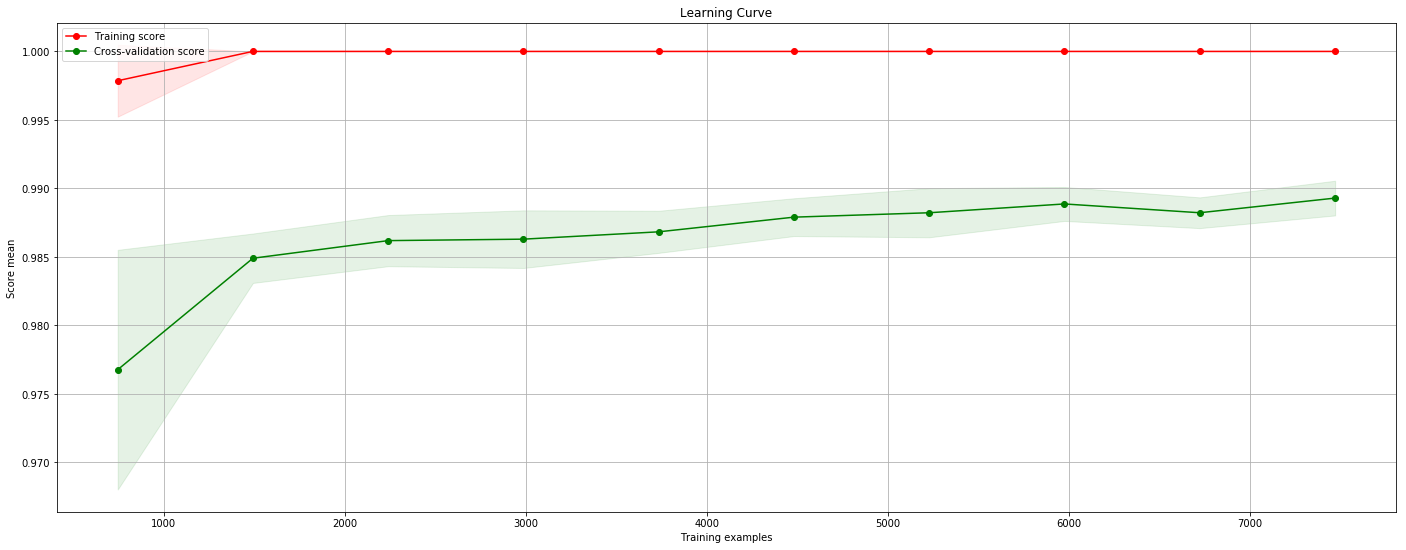

In [20]:
figure = plt.gcf()
figure.set_size_inches(24, 9)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.show()